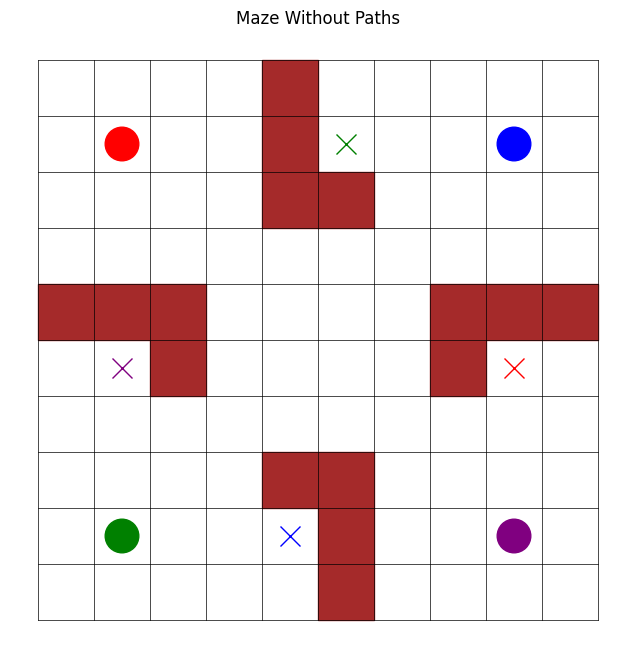

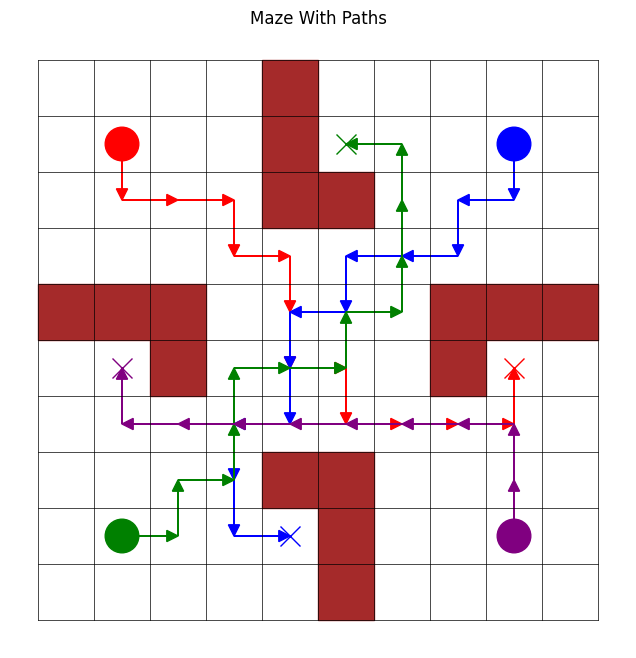

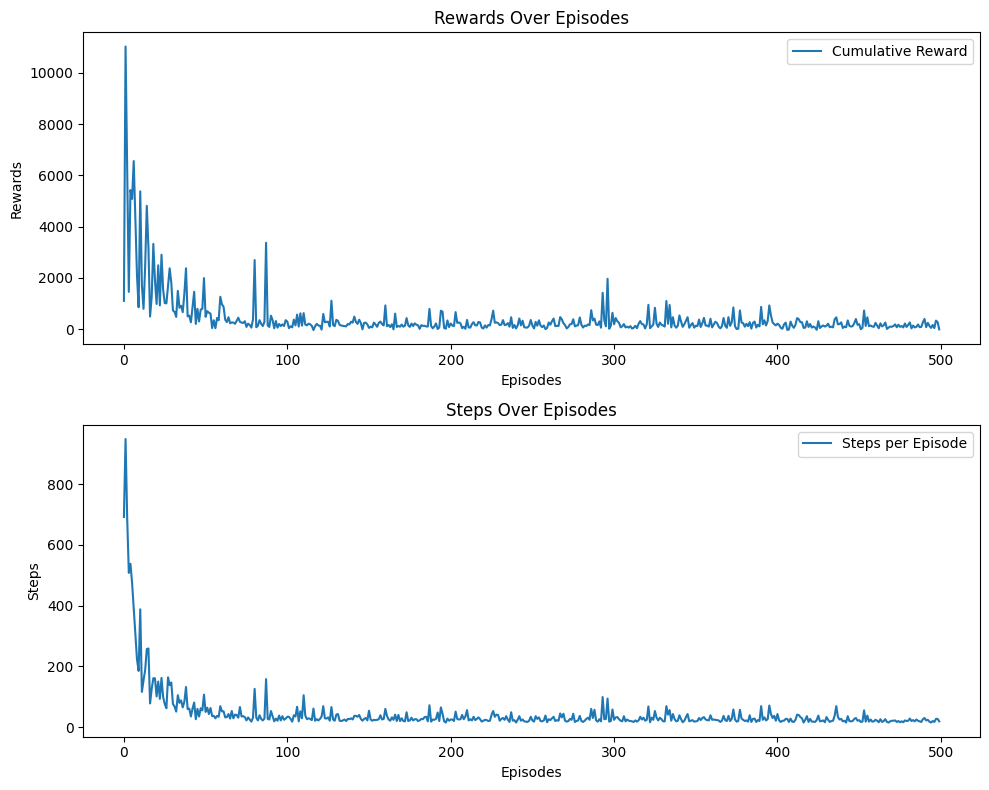

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from collections import defaultdict

# Configuration
maze_size = 10
walls = [
    (0, 4), (1, 4), (2, 4), (2, 5),
    (4, 7), (4, 8), (4, 9), (5, 7),
    (4, 0), (4, 1), (4, 2), (5, 2),
    (7, 5), (8, 5), (9, 5), (7, 4)
]
agents = [(1, 1), (1, 8), (8, 1), (8, 8)]
destinations = [(5, 8), (8, 4), (1, 5), (5, 1)]
agent_colors = ['red', 'blue', 'green', 'purple']
ACTIONS = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]  # Stay, Up, Down, Left, Right
NUM_ACTIONS = len(ACTIONS)
GAMMA, ALPHA, EPSILON = 0.9, 0.1, 0.2
MAX_EPISODES = 500

# Environment setup class
class GridSetup:
    def __init__(self, size, walls, agents, destinations):
        self.size = size
        self.walls = walls
        self.agents = agents
        self.destinations = destinations
        self.maze = np.zeros((size, size), dtype=int)
        for wall in walls:
            self.maze[wall] = 1

    def get_maze(self):
        return self.maze

    def get_agents_and_destinations(self):
        return self.agents, self.destinations

# Maze environment
class MultiAgentEnvironment:
    def __init__(self, maze, agents, destinations):
        self.maze = maze
        self.agents = agents
        self.destinations = destinations
        self.num_agents = len(agents)
        self.state = tuple(agents)

    def validate_move(self, position):
        x, y = position
        return 0 <= x < maze_size and 0 <= y < maze_size and self.maze[x, y] != 1

    def reset_environment(self):
        self.state = tuple(self.agents)
        return self.state

    def step_agents(self, actions):
        next_state = list(self.state)
        rewards = []
        for i, action in enumerate(actions):
            move = ACTIONS[action]
            new_pos = (self.state[i][0] + move[0], self.state[i][1] + move[1])
            if self.validate_move(new_pos) and new_pos not in next_state:
                next_state[i] = new_pos
            rewards.append(10 if next_state[i] == self.destinations[i] else -1)
        self.state = tuple(next_state)
        done = all(next_state[i] == self.destinations[i] for i in range(self.num_agents))
        return self.state, rewards, done

# Training function
def train_agents_in_maze(env):
    q_tables = [defaultdict(lambda: np.zeros(NUM_ACTIONS)) for _ in range(env.num_agents)]
    rewards_per_episode = []
    steps_per_episode = []

    for episode in range(MAX_EPISODES):
        state = env.reset_environment()
        total_reward = 0
        steps = 0

        while True:
            actions = []
            for i in range(env.num_agents):
                if np.random.uniform(0, 1) < EPSILON:
                    actions.append(np.random.choice(NUM_ACTIONS))  # Explore
                else:
                    actions.append(np.argmax(q_tables[i][state[i]]))  # Exploit

            next_state, rewards, done = env.step_agents(actions)

            # Update Q-tables
            for i in range(env.num_agents):
                q_tables[i][state[i]][actions[i]] += ALPHA * (
                    rewards[i]
                    + GAMMA * np.max(q_tables[i][next_state[i]])
                    - q_tables[i][state[i]][actions[i]]
                )

            state = next_state
            total_reward += sum(rewards)
            steps += 1
            if done:
                break

        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)

    return q_tables, rewards_per_episode, steps_per_episode

# Visualization without path
def visualize_maze_without_path(maze, env):
    fig, ax = plt.subplots(figsize=(8, 8))

    for x in range(maze_size):
        for y in range(maze_size):
            if maze[x, y] == 1:
                ax.add_patch(patches.Rectangle((y, maze_size - x - 1), 1, 1, color='brown'))

    for i, dest in enumerate(env.destinations):
        ax.plot(dest[1] + 0.5, maze_size - dest[0] - 1 + 0.5, marker='x', color=agent_colors[i], markersize=15)

    for i in range(env.num_agents):
        ax.add_patch(patches.Circle((env.agents[i][1] + 0.5, maze_size - env.agents[i][0] - 1 + 0.5), 0.3, color=agent_colors[i]))

    for i in range(maze_size + 1):
        ax.plot([0, maze_size], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, maze_size], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("Maze Without Paths")
    plt.show()

# Visualization with paths
def visualize_maze_with_paths(maze, env, q_tables):
    fig, ax = plt.subplots(figsize=(8, 8))

    for x in range(maze_size):
        for y in range(maze_size):
            if maze[x, y] == 1:
                ax.add_patch(patches.Rectangle((y, maze_size - x - 1), 1, 1, color='brown'))

    for i, dest in enumerate(env.destinations):
        ax.plot(dest[1] + 0.5, maze_size - dest[0] - 1 + 0.5, marker='x', color=agent_colors[i], markersize=15)

    for i in range(env.num_agents):
        current_pos = env.agents[i]
        destination = env.destinations[i]

        while current_pos != destination:
            best_action_index = np.argmax(q_tables[i][current_pos])
            move = ACTIONS[best_action_index]
            next_pos = (current_pos[0] + move[0], current_pos[1] + move[1])

            if env.validate_move(next_pos):
                ax.arrow(
                    current_pos[1] + 0.5,
                    maze_size - current_pos[0] - 1 + 0.5,
                    move[1] * 0.8,
                    -move[0] * 0.8,
                    head_width=0.2,
                    head_length=0.2,
                    fc=agent_colors[i],
                    ec=agent_colors[i],
                )
                current_pos = next_pos

        ax.add_patch(patches.Circle((env.agents[i][1] + 0.5, maze_size - env.agents[i][0] - 1 + 0.5), 0.3, color=agent_colors[i]))

    for i in range(maze_size + 1):
        ax.plot([0, maze_size], [i, i], color='black', linewidth=0.5)
        ax.plot([i, i], [0, maze_size], color='black', linewidth=0.5)

    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("Maze With Paths")
    plt.show()

# Plotting rewards and steps
def plot_training_metrics(rewards, steps):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.plot(rewards, label='Cumulative Reward')
    ax1.set_title('Rewards Over Episodes')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Rewards')
    ax1.legend()

    ax2.plot(steps, label='Steps per Episode')
    ax2.set_title('Steps Over Episodes')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Steps')
    ax2.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    grid_setup = GridSetup(maze_size, walls, agents, destinations)
    maze = grid_setup.get_maze()
    agents, destinations = grid_setup.get_agents_and_destinations()

    maze_env = MultiAgentEnvironment(maze, agents, destinations)
    q_tables, rewards_per_episode, steps_per_episode = train_agents_in_maze(maze_env)

    visualize_maze_without_path(maze, maze_env)
    visualize_maze_with_paths(maze, maze_env, q_tables)
    plot_training_metrics(rewards_per_episode, steps_per_episode)
